In [1]:
from __future__ import division

In [2]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import datetime, timedelta, date
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.cluster import KMeans

In [5]:
import xgboost as xgb

In [6]:
from sklearn.model_selection import KFold,cross_val_score, train_test_split

In [7]:
tx_data = pd.read_csv('OnlineRetail.csv',encoding="ISO-8859-1")

In [8]:
tx_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [11]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [14]:
tx_uk = tx_data.query("Country == 'United Kingdom'").reset_index(drop=True)

In [15]:
date(2017,12,3)

datetime.date(2017, 12, 3)

In [18]:
tx_3m = tx_uk[(tx_uk.InvoiceDate < date(2011,6,1)) & (tx_uk.InvoiceDate >= date(2011,3,1))].reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [19]:
tx_6m = tx_uk[(tx_uk.InvoiceDate >= date(2011,6,1)) & (tx_uk.InvoiceDate < date(2011,12,1))].reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [24]:
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())

In [27]:
tx_user.columns = ['CustomerID']

In [28]:
tx_user.head()


,CustomerID
0,14620.0
1,14740.0
2,13880.0
3,16462.0
4,17068.0


# Recency

In [29]:
tx_max_purchase = tx_3m.groupby("CustomerID").InvoiceDate.max().reset_index()

In [31]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [32]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [33]:
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12747.0,2011-05-25 09:57:00,6
1,12748.0,2011-05-31 12:50:00,0
2,12749.0,2011-05-23 17:08:00,7
3,12821.0,2011-05-09 15:51:00,21
4,12823.0,2011-03-30 10:36:00,62


In [35]:
tx_user = pd.merge(tx_user,tx_max_purchase[['CustomerID','Recency']],on='CustomerID')

In [36]:
tx_user.head()

,CustomerID,Recency
0,14620.0,12
1,14740.0,4
2,13880.0,25
3,16462.0,91
4,17068.0,11


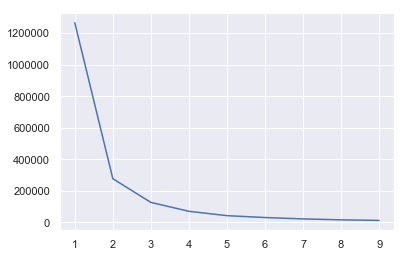

In [37]:
sse={}
tx_recency = tx_user[['Recency']]
for i in range(1,10):
    kmeans = KMeans(i,max_iter=1000).fit(tx_recency)
    sse[i] = kmeans.inertia_

plt.plot(list(sse.keys()),list(sse.values()))
plt.show()

In [38]:
kmeans = KMeans(4)
kmeans.fit(tx_recency)
tx_user['RecencyCluster'] = kmeans.predict(tx_recency)

In [39]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,14620.0,12,1
1,14740.0,4,1
2,13880.0,25,3
3,16462.0,91,2
4,17068.0,11,1


In [40]:
tf_new = tx_user.groupby("RecencyCluster")["Recency"].mean().reset_index()

In [41]:
tf_new.head()

,RecencyCluster,Recency
0,0,50.020501
1,1,8.312500
2,2,76.885387
3,3,24.373874


In [42]:
tf_new = tf_new.sort_values(by="Recency",ascending=False).reset_index()

In [43]:
tf_new.head()

,index,RecencyCluster,Recency
0,2,2,76.885387
1,0,0,50.020501
2,3,3,24.373874
3,1,1,8.312500


In [44]:
tf_new['Index'] = tf_new.index

In [45]:
tf_new.head()

,index,RecencyCluster,Recency,Index
0,2,2,76.885387,0
1,0,0,50.020501,1
2,3,3,24.373874,2
3,1,1,8.312500,3


In [46]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [47]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [48]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,14620.0,12,3
1,14740.0,4,3
2,17068.0,11,3
3,12971.0,4,3
4,15194.0,6,3


# frequency

In [49]:
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()

In [50]:
tx_frequency.columns = ['CustomerID','Frequency']

In [51]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

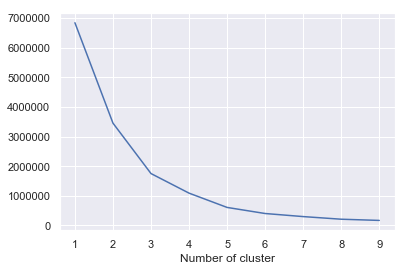

In [52]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [53]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [54]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

# Monetory Value

In [56]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']

In [57]:
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()

In [58]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [59]:
import warnings
warnings.filterwarnings("ignore")

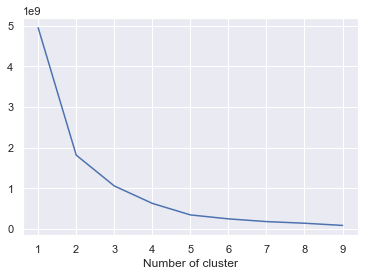

In [60]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [61]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [62]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [63]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,12,3,30,0,393.28,0
1,15194.0,6,3,64,0,1439.02,0
2,18044.0,5,3,57,0,808.96,0
3,18075.0,12,3,35,0,638.12,0
4,15241.0,0,3,64,0,947.55,0


In [64]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [65]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,77.014925,18.432836,295.824239
1,50.887828,24.522673,367.334177
2,26.590476,31.028571,500.973095
3,10.243902,36.652439,633.871402
4,8.109375,103.835938,1983.985086
5,6.482759,138.965517,4326.155172
6,7.357143,322.071429,12177.627143
7,3.000000,779.333333,11350.896667


In [66]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [67]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


# CLV

In [68]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']

In [69]:
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

In [70]:
tx_user_6m.head()

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


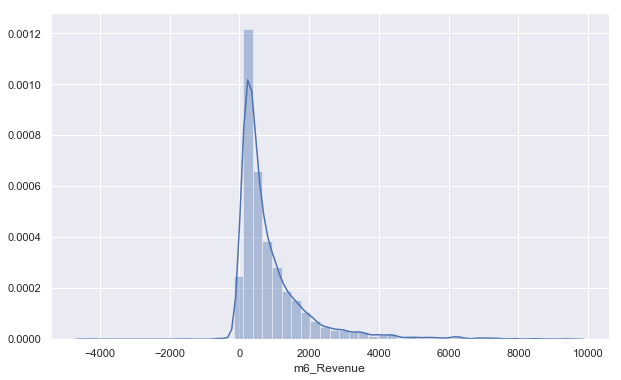

In [73]:
plt.figure(figsize=(10,6))
sns.distplot(tx_user_6m.query('m6_Revenue < 10000')['m6_Revenue'])

In [74]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')

In [75]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,NaN
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


In [76]:
tx_merge = tx_merge.fillna(0)

In [77]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


In [78]:
tx_merge.groupby('Segment')['m6_Revenue'].mean()

Segment
High-Value    17968.362609
Low-Value       703.559983
Mid-Value      1718.212598
Name: m6_Revenue, dtype: float64

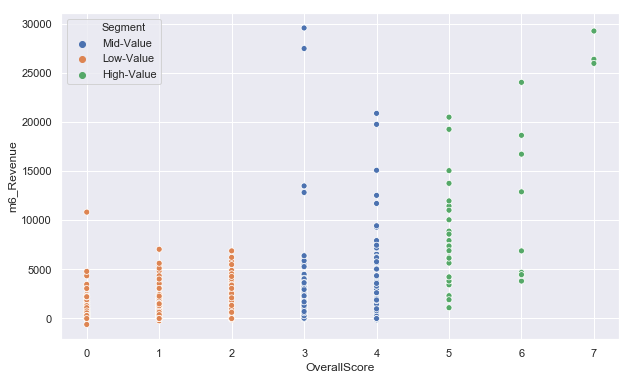

In [80]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=tx_merge.query("m6_Revenue < 30000"),x="OverallScore",y="m6_Revenue",hue="Segment")

In [81]:
tx_merge['m6_Revenue'].quantile(0.99)

17929.15699999989

In [82]:
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [83]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


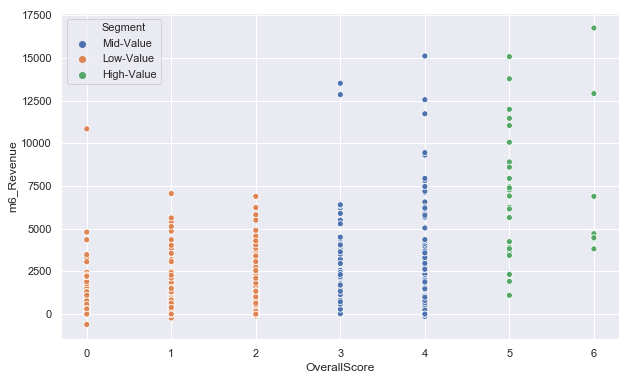

In [84]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=tx_merge,x="OverallScore",y="m6_Revenue",hue="Segment")

In [85]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

In [86]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,1
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20,2
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,1
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,1
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,1


In [87]:
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

In [88]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0
4,15660.0,4,3,34,0,484.62,0,3,Mid-Value,858.09,0


In [90]:
tx_class = pd.get_dummies(tx_cluster)

In [91]:
corr_matrix = tx_class.corr()


In [92]:
corr_matrix

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
CustomerID,1.000000,-0.002528,0.006726,-0.041699,-0.001735,-0.059981,-0.043978,-0.001481,-0.039158,-0.028401,-0.051896,0.005218,0.009580
Recency,-0.002528,1.000000,-0.965208,-0.255674,-0.217506,-0.310914,-0.176933,-0.914461,-0.250921,-0.237249,-0.153673,0.731302,-0.696642
RecencyCluster,0.006726,-0.965208,1.000000,0.250344,0.209192,0.313290,0.174159,0.941717,0.250437,0.236899,0.160735,-0.807441,0.771732
Frequency,-0.041699,-0.255674,0.250344,1.000000,0.789243,0.493238,0.340535,0.477430,0.374258,0.359601,0.470076,-0.334609,0.204241
FrequencyCluster,-0.001735,-0.217506,0.209192,0.789243,1.000000,0.457022,0.310259,0.493382,0.377632,0.366366,0.419725,-0.351350,0.235619
Revenue,-0.059981,-0.310914,0.313290,0.493238,0.457022,1.000000,0.785147,0.511996,0.738058,0.600491,0.577521,-0.364761,0.204002
RevenueCluster,-0.043978,-0.176933,0.174159,0.340535,0.310259,0.785147,1.000000,0.386682,0.620276,0.467191,0.681262,-0.240919,0.048860
OverallScore,-0.001481,-0.914461,0.941717,0.477430,0.493382,0.511996,0.386682,1.000000,0.411409,0.373114,0.354948,-0.824357,0.733234
m6_Revenue,-0.039158,-0.250921,0.250437,0.374258,0.377632,0.738058,0.620276,0.411409,1.000000,0.845933,0.475710,-0.284336,0.151711
LTVCluster,-0.028401,-0.237249,0.236899,0.359601,0.366366,0.600491,0.467191,0.373114,0.845933,1.000000,0.352387,-0.266008,0.168473


In [93]:
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.845933
Revenue               0.600491
RevenueCluster        0.467191
OverallScore          0.373114
FrequencyCluster      0.366366
Frequency             0.359601
Segment_High-Value    0.352387
RecencyCluster        0.236899
Segment_Mid-Value     0.168473
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.266008
Name: LTVCluster, dtype: float64

In [94]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

In [100]:
y.shape

(1821,)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [102]:
X_train.shape

(1729, 11)

In [103]:
X_test.shape

(92, 11)

In [120]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.83
Accuracy of XGB classifier on test set: 0.91


In [121]:
tx_class.groupby('LTVCluster').CustomerID.count()/tx_class.CustomerID.count()

LTVCluster
0    0.765513
1    0.203734
2    0.030752
Name: CustomerID, dtype: float64

In [122]:
y_pred = ltv_xgb_model.predict(X_test)

In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        70
           1       0.92      0.67      0.77        18
           2       1.00      0.75      0.86         4

   micro avg       0.91      0.91      0.91        92
   macro avg       0.94      0.80      0.86        92
weighted avg       0.91      0.91      0.91        92

